In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl

In [2]:
def train_model(df):
    """
    Cette fonction prend un DataFrame contenant les données et calcule les variables RFM.
    Elle entraîne ensuite un modèle K-Means sur les données mises à l'échelle.
    """
    # Calcul des variables RFM
    date_reference = df['order_purchase_timestamp'].max()
    recency = (date_reference - df.groupby('customer_unique_id')['order_purchase_timestamp'].max()).dt.days
    recency = recency.reset_index()
    recency.columns = ['customer_unique_id', 'recency']
    
    frequency = df.groupby('customer_unique_id')['order_id'].sum().reset_index()
    frequency.columns = ['customer_unique_id', 'frequency']
    
    monetary = df.groupby('customer_unique_id')[['price', 'freight_value']].sum().sum(axis=1).reset_index()
    monetary.columns = ['customer_unique_id', 'monetary']
    
    rfm = pd.merge(recency, frequency, on='customer_unique_id')
    rfm = pd.merge(rfm, monetary, on='customer_unique_id')
    
    # Entraînement du modèle K-Means
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(rfm[['recency', 'frequency', 'monetary']])
    model = KMeans(n_clusters=3, n_init=10).fit(scaled_data)
    
    return scaler, model, rfm

def calculate_ARI(model_M0, scaler_M0, model_M1, scaler_M1, data):
    """
    Calcule le score ARI entre les clusters prédits par M0 et M1.
    """
    scaled_data_M0 = scaler_M0.transform(data[['recency', 'frequency', 'monetary']])
    predicted_labels_M0 = model_M0.predict(scaled_data_M0)
    
    scaled_data_M1 = scaler_M1.transform(data[['recency', 'frequency', 'monetary']])
    predicted_labels_M1 = model_M1.predict(scaled_data_M1)
    
    return adjusted_rand_score(predicted_labels_M0, predicted_labels_M1)

## I- Chargement des données

In [3]:
data = pd.read_csv('df_customers.csv')
data.head()

,customer_unique_id,order_purchase_timestamp,customer_state,order_id,nb_total_item,price,freight_value,payment_type,mean_payment_installments,total_payment_value,mean_payment_value,mean_review_score,seller_state,product_category_name
0,0000366f3b9a7992bf8c76cfdf3221e2,2018-05-10 10:56:27,SP,1,1,129.90,12.00,credit_card,8.0,141.90,141.90,5.0,SP,bed_bath_table
1,0000b849f77a49e4a4ce2b2a4ca5be3f,2018-05-07 11:11:27,SP,1,1,18.90,8.29,credit_card,1.0,27.19,27.19,4.0,SP,health_beauty
2,0000f46a3911fa3c0805444483337064,2017-03-10 21:05:03,SC,1,1,69.00,17.22,credit_card,8.0,86.22,86.22,3.0,SP,stationery
3,0000f6ccb0745a6a4b88665a16c9f078,2017-10-12 20:29:41,PA,1,1,25.99,17.63,credit_card,4.0,43.62,43.62,4.0,SP,telephony
4,0004aac84e0df4da2b147fca70cf8255,2017-11-14 19:45:42,SP,1,1,180.00,16.89,credit_card,6.0,196.89,196.89,5.0,SP,telephony


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 91481 entries, 0 to 91480
Data columns (total 14 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   customer_unique_id         91481 non-null  object 
 1   order_purchase_timestamp   91481 non-null  object 
 2   customer_state             91481 non-null  object 
 3   order_id                   91481 non-null  int64  
 4   nb_total_item              91481 non-null  int64  
 5   price                      91481 non-null  float64
 6   freight_value              91481 non-null  float64
 7   payment_type               91481 non-null  object 
 8   mean_payment_installments  91481 non-null  float64
 9   total_payment_value        91481 non-null  float64
 10  mean_payment_value         91481 non-null  float64
 11  mean_review_score          91481 non-null  float64
 12  seller_state               91481 non-null  object 
 13  product_category_name      91481 non-null  obj

## II- Création du dataframe

On va utiliser le modèle identifié dans le notebook 'essais' comme étant le plus performant pour segmenter les clients. C'est le modèle Kmeans avec 4 clusters sur le dataframe contenant les colonnes suivantes :
- **recency** : date de la dernière commande
- **frequency** : fréquence des commandes
- **monetary** : montant de la dernière commande

In [5]:
data['order_purchase_timestamp'] = pd.to_datetime(data['order_purchase_timestamp'])
date_max = data['order_purchase_timestamp'].max()
date_min = data['order_purchase_timestamp'].min()

#Calculer la différence entre la date max et min
difference_jours = (date_max - date_min).days
print('Le data set va de {} à {}, soit {} jours.'.format(date_min, date_max, difference_jours))

Le data set va de 2016-10-03 16:56:50 à 2018-08-29 15:00:37, soit 694 jours.


In [6]:
# Calcul de la récence (R)
date_reference = data['order_purchase_timestamp'].max()
recency = (date_reference - data.groupby('customer_unique_id')['order_purchase_timestamp'].max()).dt.days
recency = recency.reset_index()
recency.columns = ['customer_unique_id', 'recency']

# Calcul de la fréquence (F)
rfm_frequency = data.groupby('customer_unique_id')['order_id'].sum().reset_index()
rfm_frequency.columns = ['customer_unique_id', 'frequency']

# Calcul du montant (M)
rfm_monetary = data.groupby('customer_unique_id')[['price', 'freight_value']].sum().sum(axis=1).reset_index()
rfm_monetary.columns = ['customer_unique_id', 'monetary']

# Fusionner les données
rfm = pd.merge(recency, rfm_frequency, on='customer_unique_id')
rfm = pd.merge(rfm, rfm_monetary, on='customer_unique_id')
data = pd.merge(data, rfm, on='customer_unique_id')
data.describe()

,order_purchase_timestamp,order_id,nb_total_item,price,freight_value,mean_payment_installments,total_payment_value,mean_payment_value,mean_review_score,recency,frequency,monetary
count,91481,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000,91481.000000
mean,2018-01-04 23:46:55.043495424,1.032870,1.237525,148.338325,24.753683,2.903113,212.326244,157.720299,4.154788,236.108875,1.032870,173.092009
min,2016-10-03 16:56:50,1.000000,1.000000,0.850000,0.000000,0.000000,9.590000,1.856818,1.000000,0.000000,1.000000,10.070000
25%,2017-09-18 16:17:16,1.000000,1.000000,48.900000,14.100000,1.000000,63.860000,60.750000,4.000000,113.000000,1.000000,64.000000
50%,2018-01-24 00:23:02,1.000000,1.000000,89.900000,17.730000,2.000000,112.850000,103.470000,5.000000,217.000000,1.000000,110.170000
75%,2018-05-08 12:28:59,1.000000,1.000000,159.900000,26.630000,4.000000,202.760000,174.990000,5.000000,344.000000,1.000000,188.500000
max,2018-08-29 15:00:37,14.000000,75.000000,13440.000000,1794.960000,24.000000,109312.640000,13664.080000,5.000000,694.000000,14.000000,13664.080000
std,NaN,0.206215,0.844319,243.748770,27.071499,2.679754,631.282232,215.706278,1.279158,152.586572,0.206215,257.592652


In [7]:
# Filtrer les données jusqu'au 31/12/2017
data_filtered = data[data['order_purchase_timestamp'] <= '2017-12-31']

# Entraîner le modèle initial (M0)
scaler_M0, model_M0, rfm_M0 = train_model(data_filtered)

Scores ARI pour chaque décalage : [0.31878421102444965, 0.33753207116296324, 0.3722615621179801, 0.42190570358231416, 0.4708214219909584, 0.47599833848000583, 0.5018302419792531, 0.558921903552442, 0.5797049194594073, 0.5878688859482651, 0.6196302608451288, 0.64441495891505, 0.6929538359942002, 0.7123182805695545, 0.7430106166545677, 0.7754630872003967, 0.788997963506041, 0.8101246514553936, 0.8374361426801334, 0.8688819373516675, 0.9086907064158554, 0.9634380081779925, 0.8585658144809506, 0.9849200227420086]


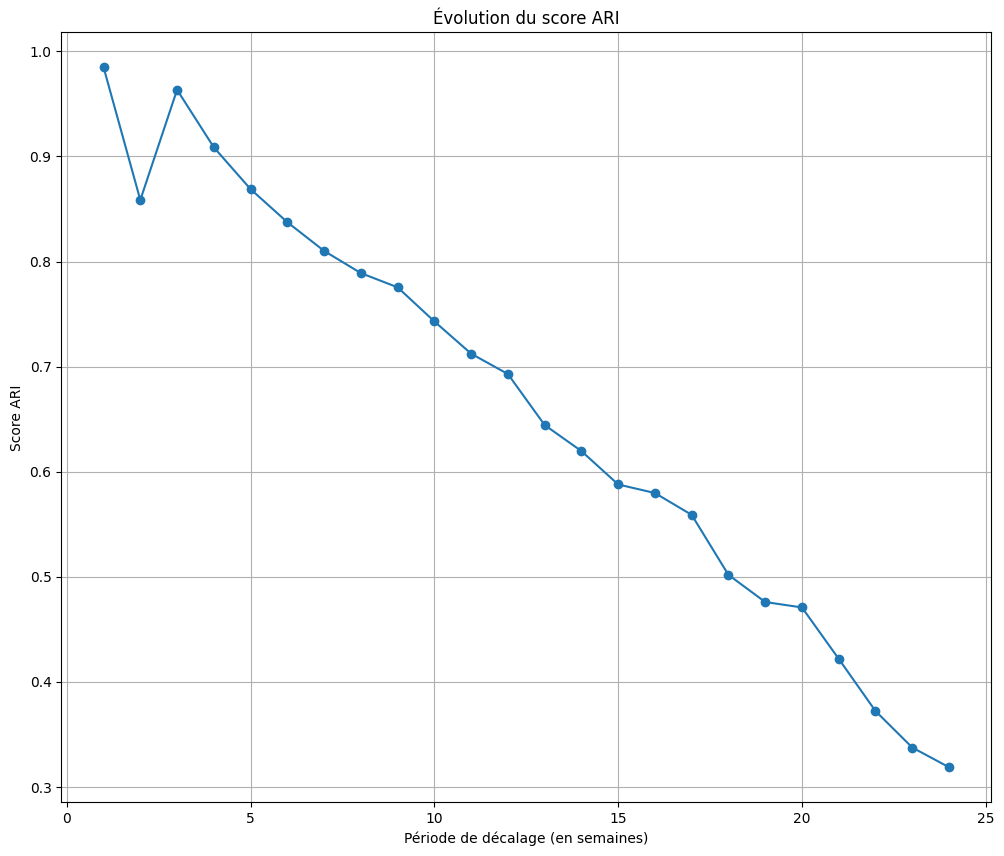

In [8]:
ARI_scores = []
shift_periods = []

# Itérer sur différentes périodes de décalage
for shift_weeks in reversed(range(1, 25)):
    shifted_df = data[data['order_purchase_timestamp'] <= data['order_purchase_timestamp'].max() - pd.Timedelta(weeks=shift_weeks)].copy()
    date_reference = shifted_df['order_purchase_timestamp'].max()
    shifted_df['date_reference'] = date_reference
    
    # Entraîner le modèle initial (M0)
    scaler_M0, model_M0, rfm_M0 = train_model(shifted_df)
    
    # Entraîner le modèle décalé (M1)
    data_filtered_M1 = data[data['order_purchase_timestamp'] <= date_reference - pd.Timedelta(weeks=shift_weeks)]
    scaler_M1, model_M1, rfm_M1 = train_model(data_filtered_M1)
    
    # Calcul du score ARI
    ARI_score = calculate_ARI(model_M0, scaler_M0, model_M1, scaler_M1, rfm_M1)
    ARI_scores.append(ARI_score)
    shift_periods.append(shift_weeks)

print("Scores ARI pour chaque décalage :", ARI_scores)

# Visualisation de l'évolution des scores ARI
plt.figure(figsize=(12,10))
plt.plot(shift_periods, ARI_scores, marker='o')
plt.title("Évolution du score ARI")
plt.xlabel("Période de décalage (en semaines)")
plt.ylabel("Score ARI")
plt.grid(True)
plt.show()

# Conclusion

Avec un seuil fixé à 0.8 pour le score ARI, il sera nécessaire de réentraîner le modèle toutes les 7 semaines environ en y ajoutant les nouvelles données.

En cas de non-réentraînement du modèle dans ce laps de temps, le clustering se décalera progressivement par rapport aux nouvelles données, ce qui risque d'entraîner des prédictions erronées et donc un mauvais ciblage de la clientèle.
